# Fit a RL model on individual data

In [1]:
import rlssm
import pandas as pd
import os

## Import individual data

In [2]:
par_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_path = os.path.join(par_path, 'data/data_experiment.csv')
data = pd.read_csv(data_path, index_col=0)

data = data[data.participant == 20].reset_index(drop=True) # Only select 1 participant

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,20,1,1,46,46,4,2,1,2.574407,1
1,20,1,2,60,33,4,2,2,1.952774,1
2,20,1,3,32,44,2,1,2,2.074999,0
3,20,1,4,56,40,4,2,3,2.320916,0
4,20,1,5,34,32,2,1,3,1.471107,1


## Initialize the model

In [3]:
# you can "turn on and off" different mechanisms:
model = rlssm.RLModel_2A(hierarchical_levels = 1,
                         increasing_sensitivity = False,
                         separate_learning_rates = True)

Using cached StanModel


In [4]:
model.priors

{'sensitivity_priors': {'mu': 1, 'sd': 50},
 'alpha_pos_priors': {'mu': 0, 'sd': 1},
 'alpha_neg_priors': {'mu': 0, 'sd': 1}}

## Fit

In [5]:
# sampling parameters
n_iter = 2000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options in a learning block (participants see 2 at a time)
initial_value_learning = 27.5 # intitial learning value (Q0)

In [6]:
model_fit = model.fit(
    data, 
    K, 
    initial_value_learning,
    sensitivity_priors={'mu': 0, 'sd': 5},
    thin = n_thin,
    iter = n_iter,
    chains = n_chains,
    verbose = False)

Fitting the model using the priors:
sensitivity_priors {'mu': 0, 'sd': 5}
alpha_pos_priors {'mu': 0, 'sd': 1}
alpha_neg_priors {'mu': 0, 'sd': 1}


Checks MCMC diagnostics:
n_eff / iter for parameter log_p_t[1] is 0.0005136779702589292!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_p_t[2] is 0.0005090424204222284!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_p_t[81] is 0.0006137657752379577!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_p_t[161] is 0.000616751650396009!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_lik[1] is 0.0005161261210126754!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_lik[2] is 0.0005103493063252117!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_lik[81] is 0.0009513954236082592!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter below 0.001 indicates that t

## get Rhat

In [7]:
model_fit.rhat

,rhat,variable
0,0.999890,alpha_pos
1,1.000694,alpha_neg
2,1.000057,sensitivity


## get wAIC

In [8]:
model_fit.waic

{'lppd': -76.0013341137295,
 'p_waic': 2.584147075766782,
 'waic': 157.17096237899256,
 'waic_se': 15.860333370240344}

## Posteriors

In [9]:
model_fit.samples.describe()

,chain,draw,transf_alpha_pos,transf_alpha_neg,transf_sensitivity
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.500000,499.500000,0.114611,0.362081,0.345694
std,0.500125,288.747186,0.063520,0.180011,0.057914
min,0.000000,0.000000,0.020200,0.010799,0.187258
25%,0.000000,249.750000,0.070945,0.230730,0.306195
50%,0.500000,499.500000,0.097523,0.329723,0.339720
75%,1.000000,749.250000,0.141440,0.449876,0.376828
max,1.000000,999.000000,0.567216,0.995145,0.789082


In [10]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

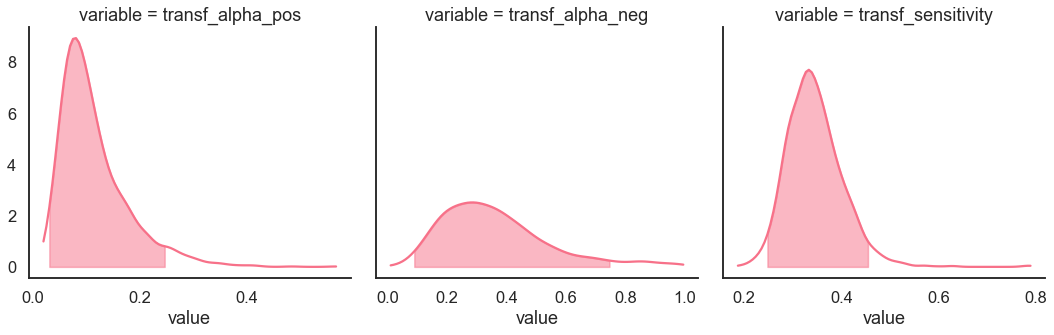

In [11]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

## Posterior predictives

### Ungrouped

In [12]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=1000)
pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 231 232 233 234   
sample                                                 ...                   
1               0   1   0   1   1   0   1   1   0   1  ...   1   1   1   1   
2               1   1   0   1   1   1   1   1   1   1  ...   0   1   1   1   
3               1   1   0   1   1   1   1   0   0   1  ...   0   0   1   0   
4               0   0   1   1   0   1   0   1   0   1  ...   0   1   1   1   
5               0   1   1   1   1   1   1   1   0   1  ...   0   0   1   1   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
996             1   1   1   1   1   0   1   0   1   1  ...   1   1   1   1   
997             1   0   1   1   1   0   1   1   0   0  ...   1   1   1   0   
998             0   1   1   1   1   1   0   0   0   1  ...   0   0   1   1   
999             1   1   1   1   1   1   1   0   0   0  ...   1   0   1   1   
1000            0   0   1   0   1   1   1   1   0   1  ...   0   1   1   1   

variable                          
trial    235 236 237 238 239 240  
sample                            
1          1   1   1   0   1   1  
2          1   1   1   0   1   1  
3          1   0   1   1   0   1  
4          1   1   1   1   1   1  
5          1   1   1   1   1   1  
...       ..  ..  ..  ..  ..  ..  
996        1   0   0   0   0   1  
997        1   1   1   1   1   1  
998        1   0   1   1   1   1  
999        1   0   1   1   0   1  
1000       1   0   1   1   1   1  

[1000 rows x 240 columns]

In [13]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=1000)
pp_summary

,mean_accuracy
sample,
1,0.804167
2,0.804167
3,0.800000
4,0.883333
5,0.825000
...,...
996,0.833333
997,0.908333
998,0.887500


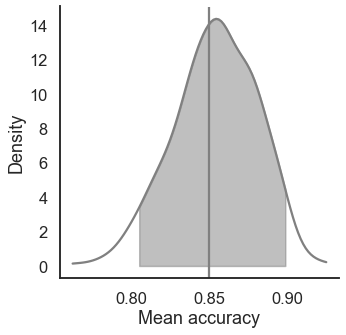

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

### Grouped

In [15]:
import numpy as np

In [16]:
# Define new grouping variables, in this case, for the different choice pairs, but any grouping var can do
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [17]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], 
                                                    n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1           1          AB          1            0.800000
                                   2            0.200000
                                   3            0.600000
                                   4            0.800000
                                   5            0.800000
...                                                  ...
3           8          CD          496          1.000000
                                   497          0.666667
                                   498          0.333333
                                   499          0.333333
                                   500          0.333333

[46000 rows x 1 columns]

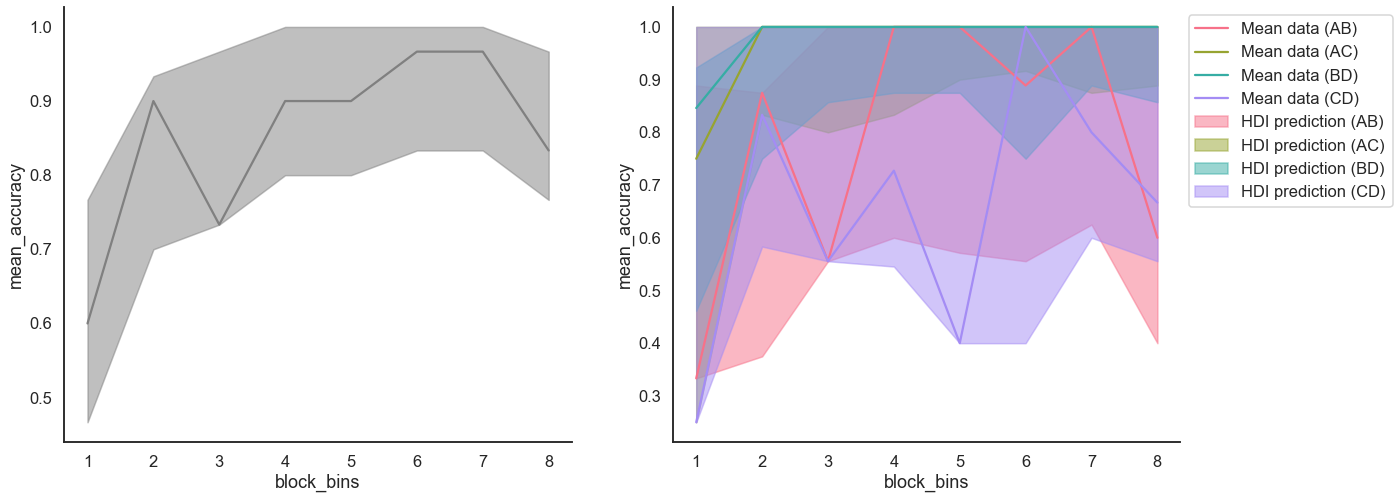

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()